# Toxic Comment Classification

The Kaggle Toxic Comment Classification Challenge is solved in this notebook. This is a multilabel classification where each comment can be classified as multiple topics simultaneously. There are 6 different types of toxicity (toxic, severe_toxic, obscene, threat, insult and identity hate), and we have detect it in test data. Data was obtained from Wikipedia's talk page edits. This notebook has the following sections:

1. Acquiring Data
2. Exploratory Data Analysis
3. Classical NLP Approach  
    3.1 Data Preparation  
    3.2 NLP model  
    3.3 Results  
4. Neural Network Approach  
    4.1 Data Preparation  
    4.2 LSTM model  
    4.3 Results  
5. Conclusions 
6. References

## 1. Acquiring Data 

Data is available in https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data. I downloaded and used 'train.csv' file. 'test.csv' wasn't used because its labels in 'test_labels.csv' contains some values labeled as -1, which indicates that it was not used for scoring in competition. 

First, let's load data as a pandas dataframe:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


There are 159571 rows and 8 columns. Each comment has an ID and labels for each type of toxicity, where 0 indicates negative and 1 indicates positive. 

## 2. Exploratory Data Analysis

Let's count the number of tags for each class to check if there is some kind of imbalance.

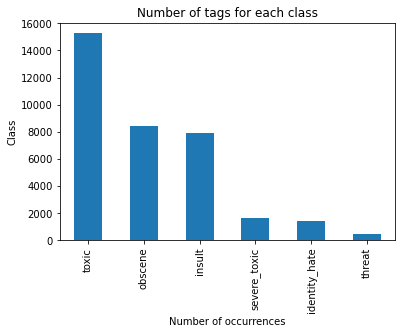

In [2]:
df.iloc[:,2:].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of tags for each class')
plt.xlabel('Number of occurrences')
plt.ylabel('Class')
plt.show()

We can see in the plot above that there is some class imbalance. There are a lot of comments labeled as 'toxic', but few comments labeled as 'severe_toxic', 'identity_hate' and 'threat'. Let's check if there is a null comment text:

In [3]:
# number of null comments
df['comment_text'].isnull().sum()

0

There aren't null comments, but a lot of comments seems to have all classes labeled as 0, which are 'clean' (normal) comments. In the cell below we see that the percentage of clean comments is 89.83%, a great part of the dataset. 

In [4]:
num_clean_comments = len(df[df.iloc[:,2:].sum(axis=1) == 0])
total = len(df)
num_toxic_comments = total - num_clean_comments
print('There are {} clean comments and {} toxic comments. {}% of all comments are clean and {}% are toxic'.format(num_clean_comments, num_toxic_comments, num_clean_comments*100/total, num_toxic_comments*100/total))

There are 143346 clean comments and 16225 toxic comments. 89.83211235124176% of all comments are clean and 10.167887648758233% are toxic


Within comments tagged with a label, it is possible to inspect how many of these comments have multiple labels. In the chart below we see that there are a lot of comments with 2 and 3 simultaneous labels.

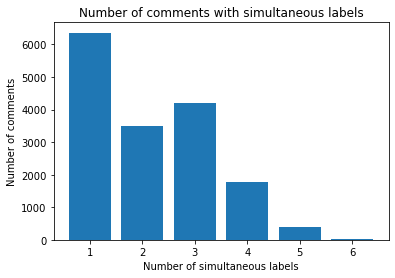

In [5]:
multi_tag = df.iloc[:,2:].sum(axis=1).value_counts().iloc[1:]
plt.bar(multi_tag.index, multi_tag.values)
plt.title('Number of comments with simultaneous labels')
plt.xlabel('Number of simultaneous labels')
plt.ylabel('Number of comments')
plt.show()

## 3. Classical NLP approach

In this section a machine learning model for NLP is developed. We will use some common NLP techniques such as term-document matrix and Tf-idf.


### 3.1 Data Preparation

First, some important libraries are imported

In [6]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\henri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Some transformations are applied to every document in the dataset:
- Substitute all characters that are not letters to blank space
- Transform all upper case characters to lower case
- Expand all contractions (e.g You're -> You are)
- Turn every document into a list of words with document.split()
- Apply lemmatization to every word in every document, which consistis in converting a word to its base form considering its context.
- Join all transformed words in each document

In [7]:
text = []
stemmer = WordNetLemmatizer()

for i in range(0, len(df['comment_text'])):
    document = re.sub("[^A-Za-z']", ' ', df['comment_text'][i])
    document = document.lower()
    document = contractions.fix(document)
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    text.append(document)

The transformed text is shown below in 'comment_text_transformed' column.

In [8]:
df['comment_text_transformed'] = text
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text_transformed
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww he match this background colour I am see...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man I am really not trying to edit war it ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,more i can not make any real suggestion on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,you sir are my hero any chance you remember wh...


We shuffle and then separate data in 70% for train and 30% for test. 

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=42, test_size=0.30, shuffle=True)

All transformed texts are stored in X_train and X_test and labels in Y_train and Y_test.

In [11]:
X_train = train['comment_text_transformed'].values
y_train = train.drop(labels=['id','comment_text','comment_text_transformed'], axis=1)
X_test = test['comment_text_transformed'].values
y_test = test.drop(labels=['id','comment_text','comment_text_transformed'], axis=1)

### 3.2 NLP model 

Let's import some important libraries.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix

First it is necessary to transform text into a term-document matrix. In this matrix each row correspond to a document and each column is every word in the dataset and the values correspond to the frequency of that word in the document. After that, we calculate the Tf-Idf, which is a statistic that measures how important a word is to both the document and the entire dataset. As we have a multilabel classification problem, in which each comment can be labeled simultaneously with different aspects (e.g: a comment can be toxic and obscene at the same time), we use the OneVsRest approach. OneVsRest decomposes the problem into multiple independent binary classifications, building one classifier per class. We will try Naive-Bayes and Logistic Regression to check which algorithm performs better. 

In [13]:
classifiers = [MultinomialNB(), LogisticRegression()]

list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for classifier in classifiers:
    print("Processing {}".format(classifier))
    pipeline = Pipeline([('vect', CountVectorizer(stop_words=stopwords.words('english'))),
                        ('tfidf', TfidfTransformer()),
                        ('classifier', OneVsRestClassifier(classifier))])
    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    conf =  multilabel_confusion_matrix(y_test, pred)
    report = classification_report(y_test, pred, target_names=list_classes)
    for i in range(0, len(list_classes)):
        acc_class = (conf[i][0][0] + conf[i][1][1])/np.sum(conf[i])
        print('Accuracy {}: {}'.format(list_classes[i], acc_class))
    print(report)

Processing MultinomialNB()


C:\Users\henri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\henri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\henri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy toxic: 0.9222092245989305
Accuracy severe_toxic: 0.9898479278074866
Accuracy obscene: 0.9524774398395722
Accuracy threat: 0.9971590909090909
Accuracy insult: 0.9522894385026738
Accuracy identity_hate: 0.990975935828877
               precision    recall  f1-score   support

        toxic       0.99      0.19      0.32      4582
 severe_toxic       0.00      0.00      0.00       486
      obscene       0.98      0.11      0.20      2556
       threat       0.00      0.00      0.00       136
       insult       0.96      0.05      0.09      2389
identity_hate       0.00      0.00      0.00       432

    micro avg       0.99      0.12      0.21     10581
    macro avg       0.49      0.06      0.10     10581
 weighted avg       0.88      0.12      0.21     10581
  samples avg       0.02      0.01      0.01     10581

Processing LogisticRegression()
Accuracy toxic: 0.9560285762032086
Accuracy severe_toxic: 0.990704378342246
Accuracy obscene: 0.976290942513369
Accuracy threat: 0.9

C:\Users\henri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\henri\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 3.3 Results
Looking at the precision, recall and accuracy values for each category, it is possible to conclude that Logistic Regression performs better than Naive Bayes, so the first is the better option. Recall values are considerably lower than precision values. This indicates a high number of false negatives, in other words, the model is labeling a lot of actual toxic comments as non-toxic. This is bad, because we are missing a lot of toxic comments.

Classes severe_toxic, threat and identity_hate had the worst results in both algorithms. This happens probably due to class imbalance, as discussed in section 2. 

To improve our chosen model, a grid search is implemented.

In [14]:
from sklearn.model_selection import GridSearchCV

grid_values = {'model__estimator__penalty':['l1', 'l2'], 'model__estimator__solver':['liblinear']}

pipeline = Pipeline([('vect', CountVectorizer(stop_words=stopwords.words('english'))),
                    ('tfidf', TfidfTransformer()),
                    ('model', OneVsRestClassifier(LogisticRegression()))])
search = GridSearchCV(pipeline, grid_values, cv=10)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)
pred = search.predict(X_test)
acc = accuracy_score(y_test, pred)
conf =  multilabel_confusion_matrix(y_test, pred)
report = classification_report(y_test, pred, target_names=list_classes)
print('Accuracy: {}'.format(acc))
for i in range(0, len(list_classes)):
    acc_class = (conf[i][0][0] + conf[i][1][1])/np.sum(conf[i])
    print('Accuracy {}: {}'.format(list_classes[i], acc_class))
print(report)

0.9195963825247542
{'model__estimator__penalty': 'l1', 'model__estimator__solver': 'liblinear'}


NameError: name 'accuracy_score' is not defined

Using l1 regularization and changing the solver improved recall values, but we'll try another approach to see how it performs.

# 4. Neural Network Approach

In this section a neural network (NN) model is built. As we have a NLP problem, a LSTM (Long-Short Term Memory) recurrent NN is used, because it is a model capable of processing sequential data. 

### 4.1 Data Preparation

We start the data preparation using the Tokenizer function, that transform the sentence in an integer array, in which each word corresponds to an integer.

In [65]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(np.concatenate((X_train,X_test))))
list_tokenized_train = tokenizer.texts_to_sequences(list(X_train))
list_tokenized_test = tokenizer.texts_to_sequences(list(X_test))

Let's check the number of words per sentence distribution:

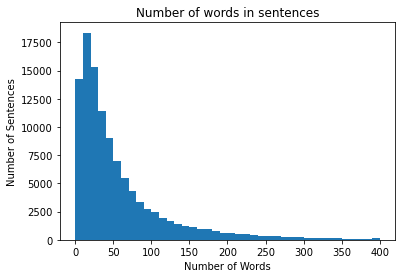

In [87]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title('Number of words in sentences')
plt.ylabel('Number of Sentences')
plt.xlabel('Number of Words')
plt.show()

The histogram above shows that most of the sentences are short and have less than 100 words, only a few have more that 200 words.

To input data in a NN it is necessary that all words arrays have the same shape, so we use pad_sequences function. If the array is shorter than the maxlen, it is filled with zeros until it has maxlen length. If it is longer, the array is truncated.  

In [75]:
maxlen = 200
X_train_processed = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_processed = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [42]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D

In [43]:
inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [44]:
from keras.models import Model
import tensorflow as tf

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[tf.keras.metrics.Precision(class_id=0, name='precision_0'),
                           tf.keras.metrics.Precision(class_id=1, name='precision_1'),
                           tf.keras.metrics.Precision(class_id=2, name='precision_2'),
                           tf.keras.metrics.Precision(class_id=3, name='precision_3'),
                           tf.keras.metrics.Precision(class_id=4, name='precision_4'),
                           tf.keras.metrics.Precision(class_id=5, name='precision_5'), 
                           tf.keras.metrics.Recall(class_id=0, name='recall_0'),
                           tf.keras.metrics.Recall(class_id=1, name='recall_1'),
                           tf.keras.metrics.Recall(class_id=2, name='recall_2'),
                           tf.keras.metrics.Recall(class_id=3, name='recall_3'),
                           tf.keras.metrics.Recall(class_id=4, name='recall_4'),
                           tf.keras.metrics.Recall(class_id=5, name='recall_5')])

In [50]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 366       
Total params: 2,605,726
Trainable params: 2,605,726
Non-trainable params: 0
_________________________________________________

In [51]:
batch_size = 256
epochs = 15
history = model.fit(X_train,y_train, batch_size=batch_size, validation_split=0.1, epochs=epochs)

C:\Users\henri\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 100529 samples, validate on 11170 samples
Epoch 1/15
100529/100529 [==============================] - 108s 1ms/step - loss: 0.1605 - recall_0: 0.0956 - recall_1: 0.0107 - recall_2: 0.0486 - recall_3: 0.0000e+00 - recall_4: 0.0571 - recall_5: 0.0000e+00 - precision_0: 4.4845e-04 - precision_1: 0.0282 - precision_2: 0.1025 - precision_3: 0.0000e+00 - precision_4: 0.0012 - precision_5: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0980 - val_recall_0: 0.9008 - val_recall_1: 0.0173 - val_recall_2: 0.0511 - val_recall_3: 0.0000e+00 - val_recall_4: 0.2122 - val_recall_5: 0.0000e+00 - val_precision_0: 0.0272 - val_precision_1: 0.0086 - val_precision_2: 0.0226 - val_precision_3: 0.0000e+00 - val_precision_4: 0.0016 - val_precision_5: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
100529/100529 [==============================] - 136s 1ms/step - loss: 0.0588 - recall_0: 0.8829 - recall_1: 0.0695 - recall_2: 0.3372 - recall_3: 0.0053 - recall_4: 0.7017 - recall_5: 0.1766 - precision_

Epoch 13/15
100529/100529 [==============================] - 145s 1ms/step - loss: 0.0198 - recall_0: 0.8951 - recall_1: 0.5785 - recall_2: 0.8511 - recall_3: 0.4127 - recall_4: 0.8156 - recall_5: 0.7242 - precision_0: 0.7694 - precision_1: 0.2904 - precision_2: 0.7623 - precision_3: 0.0595 - precision_4: 0.6947 - precision_5: 0.3059 - accuracy: 0.0000e+00 - val_loss: 0.0714 - val_recall_0: 0.8966 - val_recall_1: 0.5857 - val_recall_2: 0.8541 - val_recall_3: 0.4544 - val_recall_4: 0.8181 - val_recall_5: 0.7321 - val_precision_0: 0.7747 - val_precision_1: 0.2983 - val_precision_2: 0.7671 - val_precision_3: 0.0700 - val_precision_4: 0.7005 - val_precision_5: 0.3210 - val_accuracy: 0.0000e+00
Epoch 14/15
100529/100529 [==============================] - 143s 1ms/step - loss: 0.0182 - recall_0: 0.8982 - recall_1: 0.5936 - recall_2: 0.8570 - recall_3: 0.4902 - recall_4: 0.8213 - recall_5: 0.7402 - precision_0: 0.7802 - precision_1: 0.3073 - precision_2: 0.7718 - precision_3: 0.0824 - precisi

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Função de custo no treinamento')
plt.plot(epochs, val_loss, 'b', label='Função de custo na validação')
plt.title('Função de custo no treinamento e na validação sem Penalizing Loss Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Função de custo')
plt.legend()

plt.show()

In [52]:
test_metrics = model.evaluate(X_test,y_test)

print('\nRecall Toxic:',test_metrics[1])
print('\nRecall Severe Toxic:',test_metrics[2])
print('\nRecall Obscene:',test_metrics[3])
print('\nRecall Threat:',test_metrics[4])
print('\nRecall Insult:',test_metrics[5])
print('\nRecall Identity Hate:',test_metrics[6])
print('\nPrecision Toxic:',test_metrics[7])
print('\nPrecision Severe Toxic:',test_metrics[8])
print('\nPrecision Obscene:',test_metrics[9])
print('\nPrecision Threat:',test_metrics[10])
print('\nPrecision Insult:',test_metrics[11])
print('\nPrecision Identity Hate:',test_metrics[12])

47872/47872 [==============================] - 78s 2ms/step
